In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as pls

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
ticker = 'META'
df = yf.download(ticker, '2020-01-01')

C:\Users\S.PURDUE.23\AppData\Local\Temp\ipykernel_19444\2677720309.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [7]:
df

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2020-01-02,208.494720,208.504654,205.006231,205.483286,12077100
2020-01-03,207.391495,209.110891,205.682032,205.940449,11188400
2020-01-06,211.297409,211.476299,205.254659,205.433549,17058900
2020-01-07,211.754593,213.265284,210.452622,211.516073,14912400
2020-01-08,213.901367,214.915122,211.307358,211.694968,13475000
...,...,...,...,...,...
2025-10-28,751.440002,758.400024,745.520020,752.630005,12193800
2025-10-29,751.669983,759.159973,742.510010,754.750000,26818600


<Axes: xlabel='Date'>

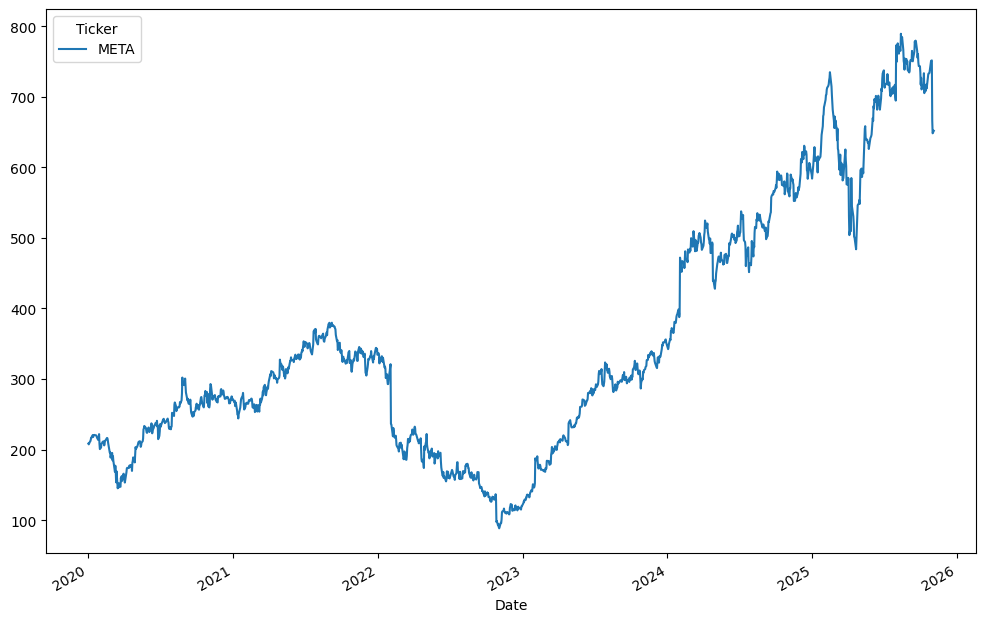

In [9]:
df.Close.plot(figsize=(12,8))

In [12]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [14]:
df.Close

Ticker,META
Date,
2020-01-02,-0.819186
2020-01-03,-0.825423
2020-01-06,-0.803343
2020-01-07,-0.800759
2020-01-08,-0.788623
...,...
2025-10-28,2.250016
2025-10-29,2.251316
2025-10-30,1.769691


In [16]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [18]:
data

array([[[-0.81918632],
        [-0.82542272],
        [-0.80334307],
        ...,
        [-0.8337378 ],
        [-0.8136806 ],
        [-0.80030927]],

       [[-0.82542272],
        [-0.80334307],
        [-0.80075867],
        ...,
        [-0.8136806 ],
        [-0.80030927],
        [-0.79446629]],

       [[-0.80334307],
        [-0.80075867],
        [-0.78862322],
        ...,
        [-0.80030927],
        [-0.79446629],
        [-0.77412815]],

       ...,

       [[ 2.40990057],
        [ 2.39933662],
        [ 2.32757332],
        ...,
        [ 2.24651127],
        [ 2.25001603],
        [ 2.25131608]],

       [[ 2.39933662],
        [ 2.32757332],
        [ 2.27240154],
        ...,
        [ 2.25001603],
        [ 2.25131608],
        [ 1.76969098]],

       [[ 2.32757332],
        [ 2.27240154],
        [ 2.30213538],
        ...,
        [ 2.25131608],
        [ 1.76969098],
        [ 1.66726089]]], shape=(1438, 30, 1))

In [42]:
train_size = int(0.8 * len(data))

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [43]:
class PredictionModel(nn.Module):

    def __init__(self,  input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [44]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [45]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [46]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.643977701663971
25 0.012839721515774727
50 0.004041588399559259
75 0.0032877237536013126
100 0.0030365160200744867
125 0.0029008255805820227
150 0.0027851948980242014
175 0.0026774415746331215


In [57]:
model.eval()

# Get predictions again from the trained model
y_train_pred = model(x_train)
y_test_pred = model(x_test)

# Convert predictions (tensors) to NumPy
y_train_pred = y_train_pred.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()

# y_train and y_test are already NumPy arrays, so don't convert them
# Inverse transform
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = scaler.inverse_transform(y_train)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

In [62]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [63]:
train_rmse

53444.3359375

In [64]:
test_rmse

115217.8359375

In [ ]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price'
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'gren', label = 'Predicted Price'
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')
